# Parametric g-formula
The g-formula is a general equation to obtain the marginal causal effect of a treatment plan. Similar to the other estimators, we assume exchangeability, positivity, and causal consistency. Additionally, if we use the parametric g-formula, we assume that our model is correctly specified. The g-formula has always fascinated me and I believe is the fundamental method for causal inference.

This tutorial details how to use the g-formula to estimate risks under a fixed regime for a single time point. To estimate the marginal risk, we will predict the outcomes under different treatment plans. For a more detailed introduction, please refer to the listed references.

To start, I will provide some intuition on how the g-formula works. There are two basic views of the g-formula that we can adopt; the standardization view versus the imputation view

### Standardization
Under the identifiability assumptions, the g-formula allows us to identify the marginal value of the potential outcome ($Y^a$) for the outcome $Y$ under treatment $A=a$. Below is the derivation
$$E[Y^a] = \sum_l E[Y^a|L=l] \Pr(L=l)$$
$$ = \sum_l E[Y^a|A=a, L=l] \Pr(L=l)$$
$$ = \sum_l E[Y|A=aL=l] \Pr(L=l)$$
where the first step uses the law of total probability, the next uses conditional exchangeability ($Y^a \amalg A|L$), and the last uses causal consistency ($Y = Y^{a=1}\times A + Y^{a=0} \times (1-A)$).

Under these assumptions, we are able to identify the average potential outcome $Y^a$ using only the observed. This is huge progress! If you look at the above formula long enough, you will notice that the g-formula is just the standardized mean. So, this is our first viewpoint of the g-formula

### Imputation
Alternatively, we can view the g-formula as an imputation procedure. Under causal consistency, we see that we only observed one of the potential outcomes. With this view, the g-formula becomes a way we can impute the missing outcomes. 

## g-computation procedure
Now that we have some intuition, what is happening behind the scenes? When $A$ and $L$ are binary, it is trivial to solve the g-formula. However, it becomes difficult to solve with many confounders (like most scenarios). The way we can get around this difficult is using parametric regression models, referred to as the g-computation algorithm in the literature. 

The process works like this:

1. Fit a regression model for the outcome as a function of the exposure and confounding variables

2. Predict outcomes $\widehat{Y_i^a}$ under the treatment plan of interest

3. Take the mean of the predicted outcomes to get $E[Y^a]$

This process is all done by `TimeFixedGFormula`. 

## Applied Example

### Binary Outcome
In the following example, use a simulated data set that comes with zEpid. For our example, we are interested in the 45-week risk of death under several different treatment strategies. Specifically, our cohort is of HIV-infected individuals and we are interested in different anti-retroviral treatment (ART) strategies. First we will load the data set and create spline terms for age and CD4

In [1]:
import numpy as np
import pandas as pd

from zepid import load_sample_data, spline
from zepid.causal.gformula import TimeFixedGFormula

df = load_sample_data(timevary=False)
df.info()

df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 9 columns):
id          547 non-null int64
male        547 non-null int64
age0        547 non-null int64
cd40        547 non-null int64
dvl0        547 non-null int64
art         547 non-null int64
dead        517 non-null float64
t           547 non-null float64
cd4_wk45    460 non-null float64
dtypes: float64(3), int64(6)
memory usage: 42.7 KB


So, there are a individuals with missing outcome data (`dead`). For now, we will assume that all missing outcome data is missing-at-random by our adjustment set. 

Through a causal diagram, we determined the sufficient adjustment set for the ART-death relationship includes; age (`age0`), baseline CD4 (`cd40`), gender (`male`), and detectable viral load (`dvl0`). We start with initializing `TimeFixedGFormula` with our data set, treatment, and outcome. Then we specify the `outcome_model()` function with our regression model specification

In [2]:
g = TimeFixedGFormula(df, exposure='art', outcome='dead')
g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                  517
Model:                            GLM   Df Residuals:                      507
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -202.85
Date:                Wed, 17 Jul 2019   Deviance:                       405.71
Time:                        12:29:38   Pearson chi2:                     535.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0961      2.713     -1.510      0.131      -9.413       1.220
art           -0.7274      0.392     -1.853      0.0

By default, `TimeFixedGFormula` outputs the regression models results. This can be suppressed by setting `print_results=False` in the `outcome_model()` function.

In most analyses that report conditional logistic regression results, we would stop here and interpret `art` as the conditional odds ratio. However, we want to make a marginal comparison comparing if we treated everyone versus treated no one with ART. To make that comparison, we will use the g-formula. The next step is to use the `fit()` function, which estimates the marginal outcome under our treatment of interest. First, we will calculate the g-formula under the scenario where everyone was treated. To do this, we will use the keyword `'all'` so that the g-formula is calculated under the scenario where everyone is treated.

After `fit()` is called, `TimeFixedGFormula` gains the attribute `marginal_outcome` which is the average of the predicted values (step 3 as above). Let's look at an example

In [3]:
g.fit(treatment='all')
r_all = g.marginal_outcome
print('Treat-all:', r_all)

Treat-all: 0.10702812052677532


Under the scenario where everyone is treated, the risk of death would have been 10.6%. We can repeat the above process for the scenario where no one is treated. To do this, we use the keyword `'none'`

In [4]:
g.fit(treatment='none')
r_none = g.marginal_outcome
print('Treat-none:', r_none)
print('RD:', r_all - r_none)

Treat-none: 0.1830498597420999
RD: -0.07602173921532457


From these results we would conclude that the 45-week risk of death when everyone was treated with ART was 7.6% points lower than if no one had been treatd with ART. 

#### Diagnostics
Diagnostics for the performance of the outcome model are available. All available diagnostics can be ran by using the function `run_diagnostics()`.

                 Natural Course Prediction Accuracy
Outcome model accuracy summary statistics. Defined as the predicted
outcome value minus the observed outcome value
----------------------------------------------------------------------
Mean value:            0.0
Standard Deviation:     0.348
Minimum value:         -0.986
Maximum value:         0.611


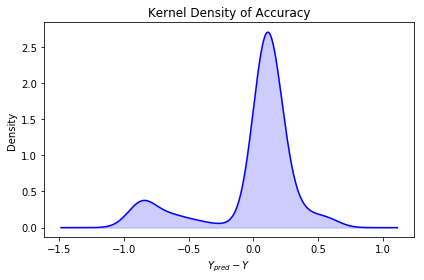

In [5]:
g.run_diagnostics()

But what about our confidence intervals? How do we get those?

#### Confidence Intervals
Unfortunately, confidence interval calculations for the g-formula are not straightforward. To get around this problem, we will use a non-parametric bootstrap. Below is some example code to show how to implement a nonparametric bootstrap with `TimeFixedGFormula` with 1000 resamplings

In [6]:
rd_results = []

for i in range(1000):
    s = df.sample(n=df.shape[0],replace=True)
    g = TimeFixedGFormula(s,exposure='art',outcome='dead')
    g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                    print_results=False)
    g.fit(treatment='all')
    r_all = g.marginal_outcome
    g.fit(treatment='none')
    r_none = g.marginal_outcome
    rd_results.append(r_all - r_none)


print('95% LCL', np.percentile(rd_results,q=2.5))
print('95% UCL', np.percentile(rd_results,q=97.5))

95% LCL -0.147226782498276
95% UCL -0.008072303245937516


Adding to our previous conclusion; the 45-week risk of death when everyone was treated with ART was 7.5% points (95% CL: -0.14, 0.00) lower than if no one had been treatd with ART.

#### Custom Treatments
One of the nice features of the g-formula is we can customize the treatment plans easily. For example, say we wanted to compare a potential world where all the women were treated with ART versus a world where no one is treated. We can do this by specifying custom treatments.

We specify custom treatments in `TimeFixedGFormula` by setting `treatment` equal to a specific condition. In the background, `TimeFixedGFormula` uses `eval()` to determine who is treated under the plan. You will notice that the treatment looks like how the inside of `loc[]` is specified. In this case, the `g` refers to the dataframe in the g-formula. For custom treatments, this "magic-g" must be used for treatments to evaluate correctly

In [7]:
g = TimeFixedGFormula(df, exposure='art', outcome='dead')
g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                print_results=False)
g.fit(treatment="g['male'] == 0")
r_women = g.marginal_outcome

print('Treat-women', r_women)
print('RD:', r_women - r_none)

Treat-women 0.16939655798998102
RD: -0.021894178631267885


From these results, we see that treating only women is better than treating no one. However, it isn't as good as treating everyone with ART. For another demonstration, let's look at a treatment strategy where we only treat individuals younger than 50 that have a CD4 T-cell count below 250

In [8]:
g = TimeFixedGFormula(df, exposure='art', outcome='dead')
g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                print_results=False)
g.fit(treatment="(g['age0'] < 50) & (g['cd40'] < 250)")
r_custom = g.marginal_outcome

print('Treat-CD4', r_custom)
print('RD:', r_custom - r_none)

Treat-CD4 0.15347553305970812
RD: -0.03781520356154078


Again, this narrow treatment regime is better than not treating anyone but is markedly worse than if we had treated everyone with ART. 

### Continuous Outcomes
In the previous example, we focused on a binary outcome. We can also estimate the effect of ART on the 45-week CD4 T-cell count (continuous variable). We will reload the data, again assuming any missing CD4 T-cell data is missing-at-random conditional on our adjustment set. Additionally, we will ignore the implications of competing risks (not recommended). 

There are two options for the distributions of continuous outcome data; normal and Poisson


#### Normal Distribution
To estimate `TimeFixedGFormula` for continuous outcome data under the assumption that it is normally distributed, we specify the optional argument `outcome_type='normal'` when initializing the g-formula

In [9]:
g = TimeFixedGFormula(df, exposure='art', outcome='cd4_wk45', outcome_type='normal')
g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + dvl0  + cd40 + cd4_rs1 + cd4_rs2')

                 Generalized Linear Model Regression Results                  
Dep. Variable:               cd4_wk45   No. Observations:                  460
Model:                            GLM   Df Residuals:                      450
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                      1.8845e+05
Method:                          IRLS   Log-Likelihood:                -3441.4
Date:                Wed, 17 Jul 2019   Deviance:                   8.4805e+07
Time:                        12:30:12   Pearson chi2:                 8.48e+07
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1046.0635    288.476      3.626      0.000     480.661    1611.466
art          247.4765     58.209      4.252      0.0

To estimate the average treatment effect (treat-all vs. treat-none), we repeat the same process as described above. Similarly, custom treatments are ran in the same way

In [10]:
g.fit(treatment='all')
r_all = g.marginal_outcome

g.fit(treatment='none')
r_none = g.marginal_outcome

print('ATE:', r_all - r_none)

ATE: 247.4764697290907


So, the 45-week CD4 T-cell count is 247.5 cells higher in the world where everyone is treated with ART compared to no one receiving ART (ignoring competing risks)

#### Poisson Distribution
We may be unwilling to assume that CD4 T-cell counts are normally distributed. Instead we can specify `outcome_type='poisson'` to use a Poisson regression model instead. Below is an example of the previous but with a Poisson model instead

In [11]:
g = TimeFixedGFormula(df, exposure='art', outcome='cd4_wk45', outcome_type='poisson')
g.outcome_model(model='art + male + age0 + age_rs1 + age_rs2 + dvl0  + cd40 + cd4_rs1 + cd4_rs2',
               print_results=False)

g.fit(treatment='all')
r_all = g.marginal_outcome

g.fit(treatment='none')
r_none = g.marginal_outcome

print('ATE:', r_all - r_none)

ATE: 246.9362145680459


Our results are fairly similar. Overall, ART treatment increases CD4 T-cell count marginally, as we would expect *a priori*

# Conclusion
In this tutorial, I discussed two ways to view the g-formula. I detailed the use of `TimeFixedGFormula` for binary treatments for both binary and continuous outcomes. I demonstrated obtaining confidence intervals through a bootstrap procedure. Lastly, I showed how to specify custom treatment plans. Please view other tutorials for further information on the functionality of `TimeFixedGFormula` and other functions in *zEpid*

## Further Readings
Snowden et al. (2011) "Implementation of G-computation on a simulated data set: demonstration of a causal inference technique." *AJE* 173.7: 731-738.

Robins. (1986) "A new approach to causal inference in mortality studies with a sustained exposure period—application to control of the healthy worker survivor effect." *Mathematical modelling* 7.9-12: 1393-1512